## Flowers Recognition 

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United 
Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light 
variations. In addition, there are categories that have large variations within the category and several very 
similar categories. 
The dataset is divided into a training set, a validation set and a test set. The training set and validation set 
each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 
6149 images (minimum 20 per class). Some tasks to consider: 
1. Modify some previously published architectures e.g., increase the network depth, reducing their 
parameters,  etc.  Explore  more  advanced  techniques  such  as  deformable  convolution,  dilated 
convolution (dilation>1) or visual prompt tuning for Transformers. 
2. Analyze the results of using fewer training images, i.e., few-shot learning 
3. Use  more  advanced  transformation  techniques  such  as  MixUp  (see  the  original  paper  and  its 
PyTorch implementation here) 
4. Try more advanced loss function such as triplet loss

## Purpose
This notebook is for experimenting with how base pre trained models handle the dataset without any modifications, before other improvements are made.

In [78]:
import platform

if platform.system() == "Darwin":  # macOS
    %pip install -r requirements_mac.txt
else:
    %pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.


## Environment Setup

This section setups the environment by doing the following:
1. Importing the dependencies
2. Checking if CUDA/mps is available on device running this notebook
3. Setting up data and output folder to store downloaded dataset and outputs
4. Setting up of transforms for data augmentation
5. Downloading of datasets after transforms are initialized
6. Setting up of hyper parameters for training
7. Creation of dataloaders and visualizing data

### 1. Importing the dependencies

In [ ]:
# Import necessary libraries
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchsummary import summary  # For model architecture visualization

### 2. Checking if CUDA/mps is available

In [80]:
# Set the device based on availability of MPS (macOS), CUDA, or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 3. Setting up data and output folders to store downloaded dataset and output later on

In [81]:
# Define the data directories to store dataset and outputs
data_dir = "./data"
output_dir = "./output" 

# Create directories if they do not exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### 4. Image Transforms and Augmentation
In the training transform, it is normalized to those values instead of (0.5, 0.5, 0.5) for both std and mean as it is common practice and was calculated based on millions of images. So we will try that for now.

Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [82]:
# Handle data transformations and augmentation for training, validation and testing
# Make a standard coefficient for all parameters of color jitter
jitter_coefficient = 0.1
normalize_std = [0.485, 0.456, 0.406]
normalize_mean = [0.229, 0.224, 0.225]

# Denormalize images for display in future
def denormalize(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array(normalize_mean)
    std = np.array(normalize_std)
    img = std * img + mean
    return np.clip(img, 0, 1)
      
# For our training data, we will apply data augmentation to improve generalization and help the model become more robust to different variations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Crop at random position and resizes
    transforms.RandomHorizontalFlip(), # This randomly flips images horizontally
    transforms.RandomRotation(20), # Randomly rotates the image within +- 20 degrees
    transforms.ColorJitter(brightness=jitter_coefficient, contrast=jitter_coefficient, saturation=jitter_coefficient, hue=jitter_coefficient), # Randomly changes brightness, contrast, saturation and hue
    transforms.ToTensor(), # Converts the image to a PyTorch tensor
    transforms.Normalize(std=normalize_std, mean=normalize_mean) # Normalizes the image with mean and std deviation (from ImageNet)
])

# For validation and testing data, we should only resize and normalize to ensure consistent results
val_test_transforms = transforms.Compose([
    transforms.Resize(256), # Resizes the image to 256x256
    transforms.CenterCrop(224), # Resizes the image to 224x224
    transforms.ToTensor(), # Converts the image to a PyTorch tensor
    transforms.Normalize(std=normalize_std, mean=normalize_mean) # Normalizes the image with mean and std deviation (from ImageNet)
])

### 5. Dataset Downloading
- Load the Oxford Flowers 102 dataset which is split into the following:
  - Training : 10 image per class (1020 images)
  - Validation : 10 image per class (1020 images)
  - Test set : remaining images (6149 images)

In [83]:
# Then download the data from source and store into the data directory
train_dataset = datasets.Flowers102(root = data_dir, split='train', transform=train_transforms, download=True)
val_dataset = datasets.Flowers102(root = data_dir, split='val', transform=val_test_transforms, download=True)
test_dataset = datasets.Flowers102(root = data_dir, split='test', transform=val_test_transforms, download=True)

# Print dataset sizes
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 1020
Validation set size: 1020
Test set size: 6149


### 6. Hyperparameters Setup

In [84]:
# Hyperparameters setup
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
AVAILABLE_MODELS = ['resnet50', 'vgg16', 'densenet121']  # Add more models as needed
MODEL = AVAILABLE_MODELS[0] # Other options include 'vgg16', 'densenet121', etc.
NUM_CLASSES = 102 # Number of classes in the dataset, Oxford 102 has 102 classes 

### 7. Creation of dataloaders and visualizing data

In [85]:
# Create our dataloaders for batching and iterators
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Store our dataloaders in a dictionary for easy access
data_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
# Store our dataset sizes in a dictionary for easy access
dataset_sizes = {
    'train': len(train_loader.dataset),
    'val': len(val_loader.dataset),
    'test': len(test_loader.dataset)
}

In [86]:
def visualize_dataset_samples(dataset, class_names, num_samples=5):
    """
    Visualize sample images from the dataset with better color preservation
    """
    # Create a DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get raw samples before normalization
    # First, save the original transform
    original_transform = dataset.transform
    
    # Temporarily remove normalization for visualization
    dataset.transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()  # Only convert to tensor, no normalization
    ])
    
    # Create a new loader with the modified transform
    raw_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get samples (both normalized and raw)
    samples = []
    raw_samples = []
    labels = []
    
    # Use the same random seed for both loaders to get same images
    torch.manual_seed(10)
    for i, (img, label) in enumerate(loader):
        if i >= num_samples:
            break
        samples.append(img[0])
        labels.append(label.item())

    torch.manual_seed(10)
    for i, (img, _) in enumerate(raw_loader):
        if i >= num_samples:
            break
        raw_samples.append(img[0])
    
    # Restore the original transform
    dataset.transform = original_transform
    
    # Plot samples side by side (normalized vs. raw)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i, (norm_img, raw_img, label) in enumerate(zip(samples, raw_samples, labels)):
        # Denormalize the normalized image
        norm_img = norm_img.cpu().numpy().transpose((1, 2, 0))
        mean = np.array(normalize_mean) # This is same value as the one used in normalization
        std = np.array(normalize_std)
        denorm_img = std * norm_img + mean
        denorm_img = np.clip(denorm_img, 0, 1)
        
        # Convert raw image to numpy
        raw_img = raw_img.cpu().numpy().transpose((1, 2, 0))
        
        # Plot denormalized image
        axes[0, i].imshow(denorm_img)
        axes[0, i].set_title(f"Denormalized")
        axes[0, i].axis('off')
        
        # Plot raw image
        axes[1, i].imshow(raw_img)
        axes[1, i].set_title(f"Original: {class_names[label]}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

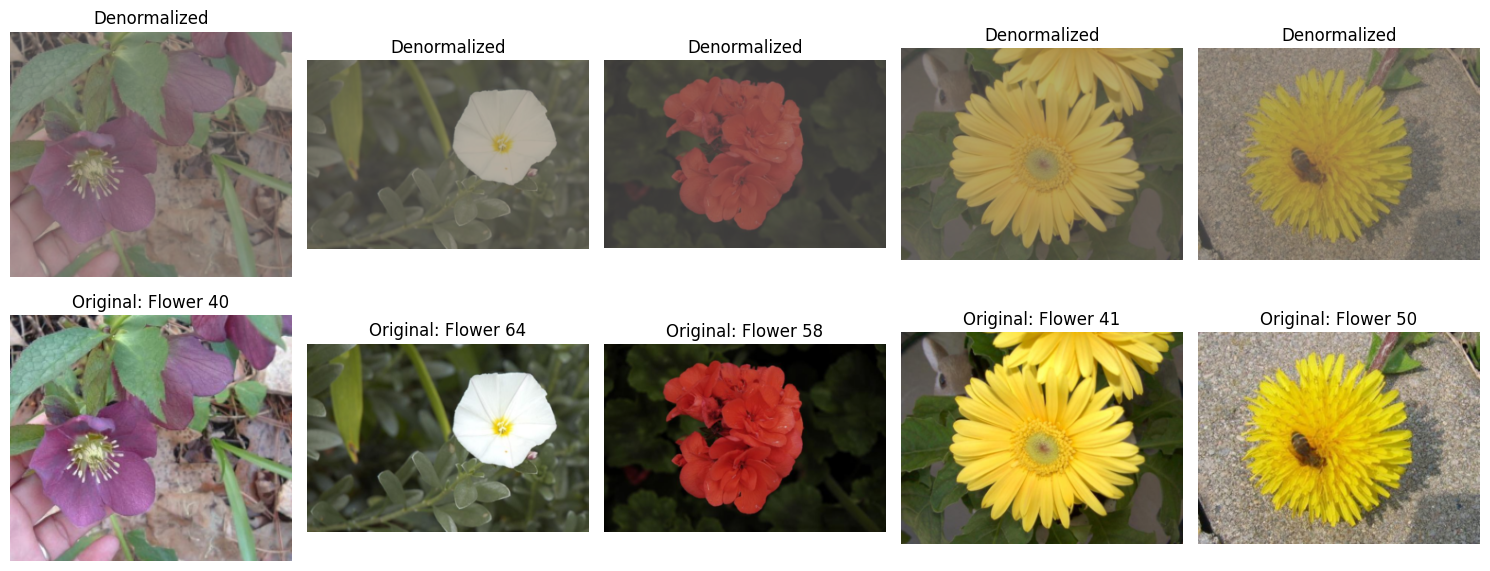

In [87]:
# Visualize training samples
# Generate class names (flower categories 1-102)
class_names = [f"Flower {i+1}" for i in range(NUM_CLASSES)]
# Using a separate dataset with non-augmented transforms for clearer visualization
visualization_dataset = datasets.Flowers102(
    root=data_dir,
    split='train',
    download=False,  # Already downloaded above
    transform=val_test_transforms  # Using non-augmented transforms for visualization
)

visualize_dataset_samples(visualization_dataset, class_names, num_samples=5)

In [88]:
class BaselineModel:
    """
    Class for the baseline model using a pretrained architecture
    """
    def __init__(self, num_classes, model_name='resnet50'):
        self.num_classes = num_classes
        self.model_name = model_name
        
        # Initialize the model
        self.model = self._initialize_model()
        self.model = self.model.to(device)  # Move to GPU if available
        
        # Set loss function - Cross Entropy is standard for classification
        self.criterion = nn.CrossEntropyLoss()
    
    def _initialize_model(self):
        """
        Initialize a pretrained model without any modifications
        """
        # For this baseline, we'll use ResNet50 without any modifications
        # You can replace this with other architectures like VGG, DenseNet, EfficientNet, etc.
        if self.model_name == 'resnet50':
            model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            # Replace the final fully connected layer
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == 'vgg16':
            model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            # Replace the final classifier
            num_ftrs = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_ftrs, self.num_classes)
        
        elif self.model_name == 'densenet121':
            model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
            # Replace the final classifier
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, self.num_classes)
            
        return model
    
    def set_optimizer(self, lr=0.001):
        """
        Set the optimizer for training
        """
        # Using SGD with momentum - reliable optimizer for many computer vision tasks
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        
        # Learning rate scheduler - reduce learning rate when validation loss plateaus
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', 
                                                      factor=0.1, patience=5, verbose=True)
        
    def train_model(self, data_loaders, dataset_sizes, num_epochs=25, save_path=None):
        """
        Train the model
        """
        # Track best model weights
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        # Track training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        # Track the time
        start_time = time.time()
        
        # Training loop
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data
                for inputs, labels in tqdm(data_loaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    self.optimizer.zero_grad()
                    
                    # Forward pass - track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store history
                if phase == 'train':
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                else:
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc.item())
                    # Update scheduler based on validation loss
                    self.scheduler.step(epoch_loss)
                
                # Save best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    if save_path:
                        torch.save(self.model.state_dict(), save_path)
            
            print()
        
        # Report training time
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        
        return history
    
    def evaluate_model(self, data_loader):
        """
        Evaluate the model on the test set
        """
        self.model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []
        
        # No gradient computation needed for evaluation
        with torch.no_grad():
            for inputs, labels in tqdm(data_loader, desc='Testing'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Store predictions and labels for further analysis
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate test loss and accuracy
        dataset_size = len(data_loader.dataset)
        test_loss = running_loss / dataset_size
        test_acc = running_corrects.float() / dataset_size
        
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
        
        return test_loss, test_acc, all_preds, all_labels
    
    def save_model(self, path):
        """
        Save the model to disk
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
        
    def load_model(self, path):
        """
        Load a saved model from disk
        """
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [89]:
def plot_training_history(history, save_path=None):
    """
    Plot training and validation loss and accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [90]:
model = BaselineModel(num_classes=NUM_CLASSES, model_name=MODEL)

# Display model architecture summary
print(f"\nModel Architecture: {MODEL}")
if torch.cuda.is_available():
    summary(model.model, (3, 224, 224), device=device.type)
else:
    print("CUDA not available for model summary visualization.")

# Configure optimizer
model.set_optimizer(lr=LEARNING_RATE)


Model Architecture: resnet50
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      Bat

c:\Users\isaac\Documents\GitHub\flowers-recognition\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [91]:
model_save_path = os.path.join(output_dir, f'{MODEL}_baseline.pth')
history = model.train_model(data_loaders, dataset_sizes, NUM_EPOCHS, model_save_path)

Epoch 1/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.6659 Acc: 0.0118


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.4773 Acc: 0.0706

Epoch 2/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.4419 Acc: 0.0775


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.1738 Acc: 0.2245

Epoch 3/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.1398 Acc: 0.2461


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.7343 Acc: 0.3941

Epoch 4/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.7994 Acc: 0.4000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2438 Acc: 0.4765

Epoch 5/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.3926 Acc: 0.4912


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.7980 Acc: 0.5725

Epoch 6/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0321 Acc: 0.5343


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.3820 Acc: 0.6069

Epoch 7/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6708 Acc: 0.6206


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.0818 Acc: 0.6814

Epoch 8/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.3457 Acc: 0.6676


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.8194 Acc: 0.7039

Epoch 9/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.1100 Acc: 0.6863


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.5694 Acc: 0.7500

Epoch 10/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.8653 Acc: 0.7167


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.3988 Acc: 0.7588

Epoch 11/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.6660 Acc: 0.7637


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.2469 Acc: 0.7804

Epoch 12/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.4872 Acc: 0.7882


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 1.0996 Acc: 0.8069

Epoch 13/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.3883 Acc: 0.7912


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9720 Acc: 0.8275

Epoch 14/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.2166 Acc: 0.8167


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.9147 Acc: 0.8314

Epoch 15/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 1.0900 Acc: 0.8480


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.8354 Acc: 0.8549

Epoch 16/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.9784 Acc: 0.8549


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.7665 Acc: 0.8529

Epoch 17/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.9106 Acc: 0.8667


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.7263 Acc: 0.8578

Epoch 18/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.8517 Acc: 0.8657


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6733 Acc: 0.8657

Epoch 19/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7459 Acc: 0.9000


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6267 Acc: 0.8833

Epoch 20/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.7442 Acc: 0.8941


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5915 Acc: 0.8882

Epoch 21/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6282 Acc: 0.9176


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5649 Acc: 0.8902

Epoch 22/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.6368 Acc: 0.9078


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5362 Acc: 0.8931

Epoch 23/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5917 Acc: 0.9157


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5735 Acc: 0.8745

Epoch 24/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.5597 Acc: 0.9206


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5278 Acc: 0.8941

Epoch 25/25
----------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.4656 Acc: 0.9304


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5021 Acc: 0.8941

Training complete in 7m 5s
Best val Acc: 0.8941


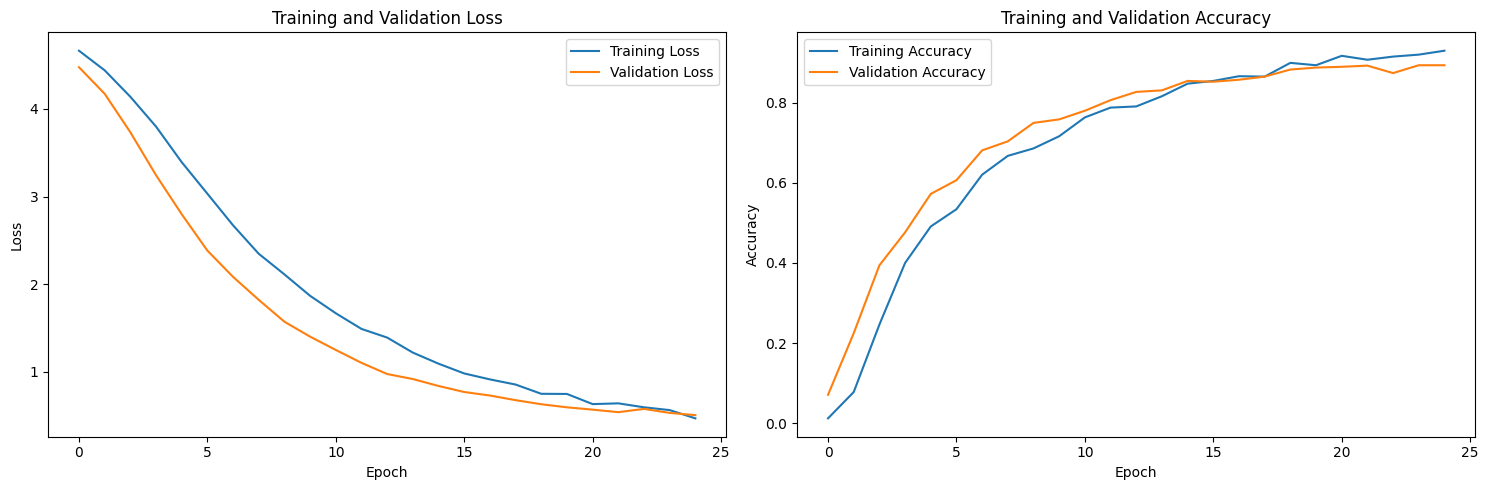

Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.5894 Acc: 0.8684
Final Test Accuracy: 0.8684

Model Parameter Information:
Total parameters: 23,717,030
Trainable parameters: 23,717,030
Non-trainable parameters: 0


In [92]:
# Plot training history
plot_training_history(history)

# Evaluate on test set
test_loss, test_acc, all_preds, all_labels = model.evaluate_model(data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {test_acc:.4f}")

# Calculate and print parameter count
total_params = sum(p.numel() for p in model.model.parameters())
trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)

print(f"\nModel Parameter Information:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Save complete model (including optimizer state)
model_checkpoint_path = os.path.join(output_dir, f'{MODEL}_baseline_checkpoint.pth')
model.save_model(model_checkpoint_path)

Finding closest images for misclassification 1/5...
Finding closest images for misclassification 2/5...
Finding closest images for misclassification 3/5...
Finding closest images for misclassification 4/5...
Finding closest images for misclassification 5/5...


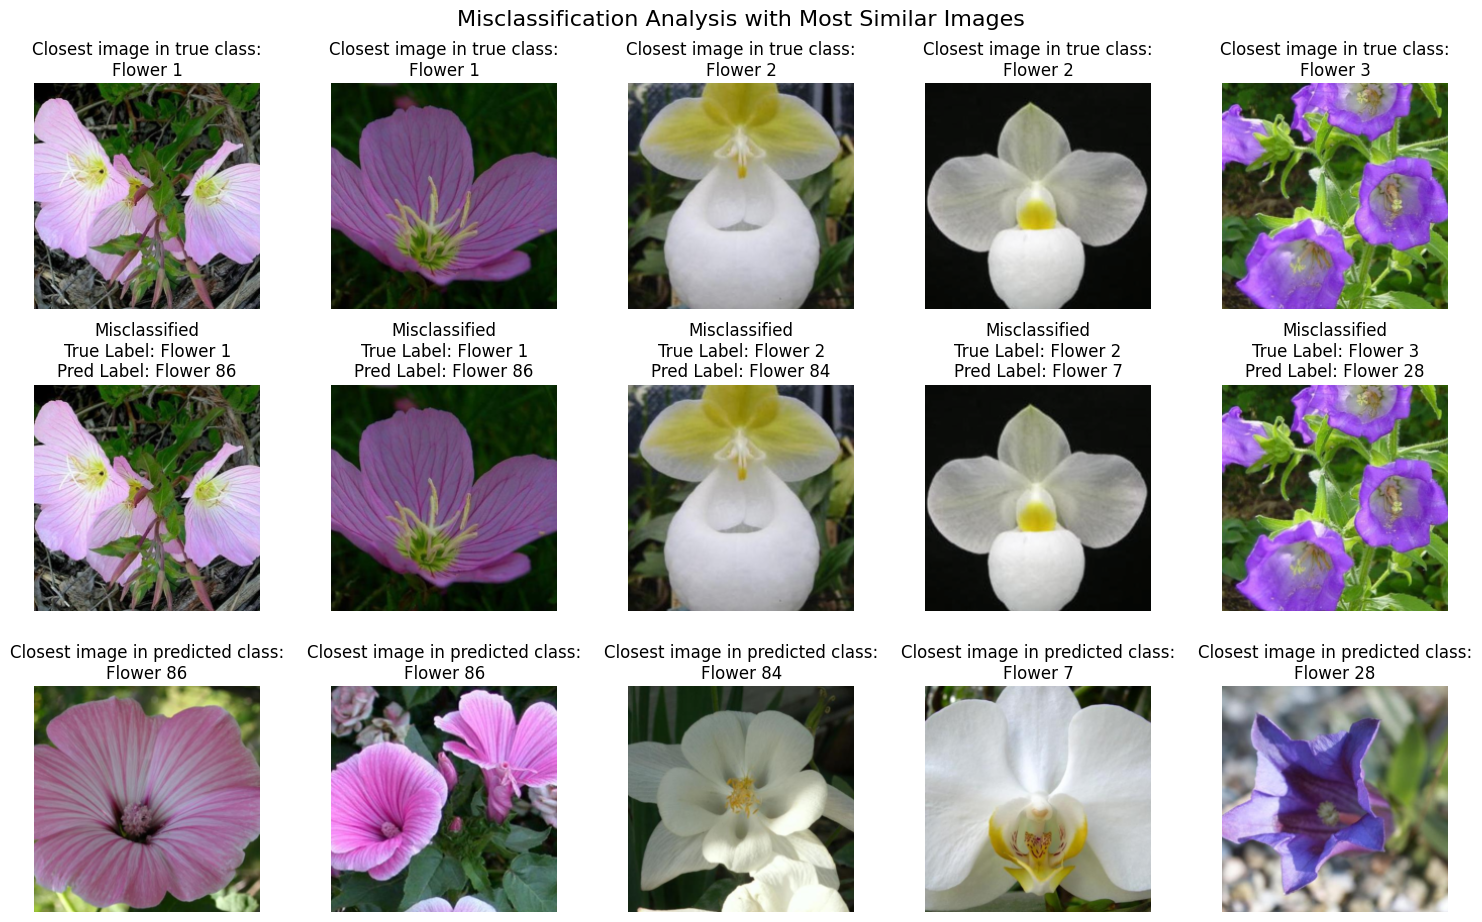

In [93]:
import torch.nn.functional as F

def visualize_misclassifications_with_closest_images(model, data_loader, class_names, dataset, num_samples=5):
    """
    Find and visualize misclassified images, along with the closest examples 
    of both the correct class and predicted class
    
    Args:
        model: The model to evaluate
        data_loader: DataLoader containing test images
        class_names: List of class names
        dataset: The full dataset to find examples from
        num_samples: Number of misclassifications to display
    """
    model.model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_features = []
    
    # Find misclassified images and extract their features
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get model outputs
            outputs = model.model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Get feature representations based on the model used and assuming we can access the penultimate layer
            features = get_features(model, inputs)
            
            for i in range(len(inputs)):
                if preds[i] != labels[i]:
                    misclassified_images.append(inputs[i].cpu())
                    misclassified_labels.append(labels[i].item())
                    misclassified_preds.append(preds[i].item())
                    misclassified_features.append(features[i].cpu())
                    
                    if len(misclassified_images) >= num_samples:
                        break
            
            if len(misclassified_images) >= num_samples:
                break
    
    # If we didn't find any misclassifications, return
    if not misclassified_images:
        print("No misclassifications found in the batches checked")
        return
        
    # Find closest images for each misclassification
    # The closest true class should return the same image as the test image, and this is just to test the correctness of the similarity function
    closest_true_class_images = []
    # This is to determine and get insights on why the model decided to predict it as such
    closest_pred_class_images = []
    
    for idx, (features, true_label, pred_label) in enumerate(zip(misclassified_features, 
                                                                misclassified_labels, 
                                                                misclassified_preds)):
        print(f"Finding closest images for misclassification {idx+1}/{len(misclassified_images)}...")
        
        # Find closest image in true class
        closest_true = find_closest_image(model, dataset, features, true_label)
        closest_true_class_images.append(closest_true)
        
        # Find closest image in predicted class
        closest_pred = find_closest_image(model, dataset, features, pred_label)
        closest_pred_class_images.append(closest_pred)
    
    # Plot misclassified images along with closest true class and predicted class examples
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    
    for i, (wrong_img, true_label, pred_label, true_img, pred_img) in enumerate(
            zip(misclassified_images, misclassified_labels, misclassified_preds, 
                closest_true_class_images, closest_pred_class_images)):
        
        if i >= num_samples:
            break
            
        # Plot closest true class image (row 0)
        true_example_img = denormalize(true_img)
        axes[0, i].imshow(true_example_img)
        axes[0, i].set_title(f"Closest image in true class:\n{class_names[true_label]}")
        axes[0, i].axis('off')
        
        # Plot misclassified image (row 1)
        wrong_img_display = denormalize(wrong_img)
        axes[1, i].imshow(wrong_img_display)
        axes[1, i].set_title(f"Misclassified\nTrue Label: {class_names[true_label]}\nPred Label: {class_names[pred_label]}")
        axes[1, i].axis('off')
        
        # Plot closest predicted class image (row 2)
        pred_example_img = denormalize(pred_img)
        axes[2, i].imshow(pred_example_img)
        axes[2, i].set_title(f"Closest image in predicted class:\n{class_names[pred_label]}")
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Misclassification Analysis with Most Similar Images", y=1.02, fontsize=16)
    plt.show()

# Helper function to extract features from the model
def get_features(model, inputs):
    """
    Extract features from the penultimate layer of the model
    """
    
    feature_extractor = copy.deepcopy(model.model)
    
    # 2. Remove the final fully connected layer
    if hasattr(feature_extractor, 'fc'):
        # For ResNet
        original_fc = feature_extractor.fc
        feature_extractor.fc = nn.Identity()
    elif hasattr(feature_extractor, 'classifier'):
        # For VGG, DenseNet, etc.
        original_classifier = feature_extractor.classifier
        if isinstance(original_classifier, nn.Sequential):
            feature_extractor.classifier = nn.Sequential(
                *list(original_classifier.children())[:-1]
            )
        else:
            feature_extractor.classifier = nn.Identity()
    
    # 3. Extract features
    with torch.no_grad():
        features = feature_extractor(inputs)
    
    return features

# Helper function to find the closest image in a dataset to a given feature vector
def find_closest_image(model, dataset, target_features, target_class):
    """
    Find the image in the dataset with the closest feature representation to target_features
    and belonging to target_class
    """
    closest_img = None
    min_distance = float('inf')
    
    # Create a smaller dataset with just the target class to speed up search
    target_indices = [i for i in range(len(dataset)) if dataset[i][1] == target_class]
    
    # Process in batches to speed up computation
    batch_size = 32
    
    # Move target_features to the same device as the model
    target_features = target_features.to(device)
    target_features_normalized = F.normalize(target_features, p=2, dim=0)
    
    for i in range(0, len(target_indices), batch_size):
        batch_indices = target_indices[i:i+batch_size]
        
        # Load batch images
        batch_imgs = []
        for idx in batch_indices:
            img, _ = dataset[idx]
            batch_imgs.append(img)
        
        # Convert to tensor and move to device
        batch_tensor = torch.stack(batch_imgs).to(device)
        
        # Extract features
        with torch.no_grad():
            batch_features = get_features(model, batch_tensor)
        
        # Compute cosine similarity
        batch_features_normalized = F.normalize(batch_features, p=2, dim=1)
        similarities = torch.mm(
            batch_features_normalized, 
            target_features_normalized.unsqueeze(1)
        ).squeeze()
        
        # Find most similar in this batch
        batch_max_sim, batch_max_idx = similarities.max(0)
        similarity = batch_max_sim.item()
        distance = 1 - similarity  # Convert similarity to distance
        
        if distance < min_distance:
            min_distance = distance
            closest_img = batch_imgs[batch_max_idx].cpu()  # Move back to CPU for storing
    
    return closest_img

visualize_misclassifications_with_closest_images(model, data_loaders['test'], class_names, test_dataset)